# T2: Downstream Proteomics

Analyzing downstream proteomics is fun!  
In this tutorial we will show you how to take a quick look at your data, check the proteomic distributions.  
Filter the dataset to remove low quality proteins, and impute the data for dimensionality reduction.  
Then we perform some simple statistical test and plot it with the famous volcano plot.

## Introduction

### Package import 

In [1]:
import opendvp as dvp
import pandas as pd
import numpy as np
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

print(f"openDVP version {dvp.__version__}")

openDVP version 0.6.4


/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load DIANN data into an adata object

Mass spectrometers produce spectra of your protein fragments.  
These peaks needs to be mapped to peptides from a database, and then infer the present proteins.

We use [DIANN](https://github.com/vdemichev/DiaNN), a software tool used to streamline this process and obtain a relative quantfication of our proteins.  
We now use one of the `DIANN` outputs, the protein group matrix (`pg_matrix`), to perform downstream analysis.

Therefore, our first step is to convert DIANN to adata.

In [2]:
adata = dvp.io.DIANN_to_adata(
    DIANN_path="../data/proteomics/DIANN_pg_matrix.csv",
    DIANN_sep="\t",
    metadata_path="../data/proteomics/DIANN_metadata.csv",
    metadata_sep=";",
    n_of_protein_metadata_cols=4,
)

16:49:01.64 | INFO | Starting DIANN matrix shape (7030, 14)
16:49:01.64 | INFO | Removing 264 contaminants
16:49:01.65 | INFO | Filtering 3 genes that are NaN
16:49:01.65 | INFO | ['A0A0G2JRQ6_HUMAN', 'A0A0J9YY99_HUMAN', 'YJ005_HUMAN']
16:49:01.66 | INFO | 10 samples, and 6763 proteins
16:49:01.67 | INFO | 52 gene lists (eg 'TMA7;TMA7B') were simplified to ('TMA7').
16:49:01.67 | SUCCESS | Anndata object has been created :) 


This function performs of helpful functionalities under the hood:
1. It removes known [contaminants](https://github.com/HaoGroup-ProtContLib/Protein-Contaminant-Libraries-for-DDA-and-DIA-Proteomics) from your samples.
2. It removes any protein groups that do not have a valid gene name (NaN)
3. Gene strings like `'TMA7;TMA7B'` are simplified to `TMA7` for streamlining with other tools.

### Quick look at adata object

In [3]:
adata

AnnData object with n_obs × n_vars = 10 × 6763
    obs: 'Precursors.Identified', 'Proteins.Identified', 'Average.Missed.Tryptic.Cleavages', 'LCMS_run_id', 'RCN', 'RCN_long', 'QuPath_class'
    var: 'Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description'

In [4]:
# Quantification values, we can see missing values already :)
adata.X[:5, :5]

array([[     nan,  5387.49, 10755.7 , 21750.3 , 20374.3 ],
       [ 9623.48,      nan,      nan,  8450.09,      nan],
       [ 8161.97,      nan,      nan, 14534.7 , 16192.5 ],
       [ 7438.25,      nan,      nan,  7547.04, 13379.7 ],
       [     nan,      nan,  9925.7 , 19308.4 , 16956.7 ]])

In [5]:
# Variable metadata, in this case proteins/genes
adata.var.head()

Protein.Group            Protein.Names               Genes  \
Gene                                                                       
TMA7      A0A024R1R8;Q9Y2S6   TMA7B_HUMAN;TMA7_HUMAN          TMA7;TMA7B   
IGLV8-61         A0A075B6I0              LV861_HUMAN            IGLV8-61   
IGLV3-10         A0A075B6K4              LV310_HUMAN            IGLV3-10   
IGLV3-9          A0A075B6K5               LV39_HUMAN             IGLV3-9   
IGKV2-28  A0A075B6P5;P01615  KV228_HUMAN;KVD28_HUMAN  IGKV2-28;IGKV2D-28   

                            First.Protein.Description  
Gene                                                   
TMA7      Translation machinery-associated protein 7B  
IGLV8-61          Immunoglobulin lambda variable 8-61  
IGLV3-10          Immunoglobulin lambda variable 3-10  
IGLV3-9            Immunoglobulin lambda variable 3-9  
IGKV2-28           Immunoglobulin kappa variable 2-28

In [6]:
# Observations metadata, in this case each proteomic sample
adata.obs.head()

Precursors.Identified  Proteins.Identified  \
Sample_filepath                                               
Sample_1                         26358                 4760   
Sample_2                         24705                 4553   
Sample_3                         26750                 4835   
Sample_4                         24268                 4502   
Sample_5                         27883                 4858   

                 Average.Missed.Tryptic.Cleavages  LCMS_run_id   RCN  \
Sample_filepath                                                        
Sample_1                                    0.139         8674  RCN1   
Sample_2                                    0.134         8452  RCN1   
Sample_3                                    0.134         8414  RCN1   
Sample_4                                    0.116         8551  RCN1   
Sample_5                                    0.136         8424  RCN1   

                       RCN_long QuPath_class  
Sample_filepath                               
Sample_1         Tumor enriched  P12_Tumor_1  
Sample_2         Tumor enriched  P12_Tumor_2  
Sample_3         Tumor enriched  P12_Tumor_3  
Sample_4         Tumor enriched  P12_Tumor_4  
Sample_5         Tumor enriched  P12_Tumor_5

## Describing the dataset

This dataset is a subset of the Triple Negative Breast Cancer dataset investigated in the openDVP paper.  
Briefly, we performed image analysis, and based on the recurrent cellular neighborhoods(RCN) we performed our laser microddisection.  
We collected samples from tumor enriched areas and immune enriched areas.  
Here we explore how their proteomes differ.

In [8]:
adata.obs.columns

Index(['Precursors.Identified', 'Proteins.Identified',
       'Average.Missed.Tryptic.Cleavages', 'LCMS_run_id', 'RCN', 'RCN_long',
       'QuPath_class'],
      dtype='object')

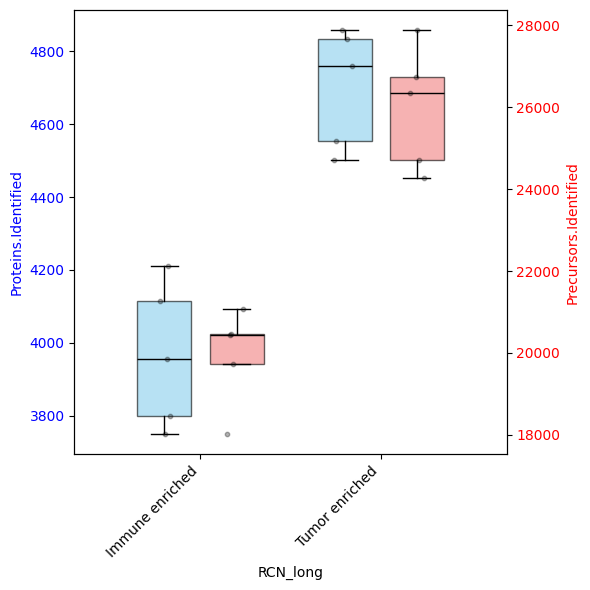

In [ ]:
# Let's see how many proteins and precursors were measured per sample
dvp.plotting.dual_axis_boxplots(
    adata=adata, feature_1="Proteins.Identified", feature_2="Precursors.Identified", group_by="RCN_long"
)

### Exploring the protein quantification

Modern mass spectrometry workflows have a dynamic range of 5 to 6 orders of magnitude.  
To have a more statistically normal distribution, and have a more intuitive range of data, we use log2 transformation.

In [11]:
print(f"Maximum value: {np.nanmax(adata.X)}")
print(f"Minimum value: {np.nanmin(adata.X)}")

Maximum value: 11506600.0
Minimum value: 251.795


In [12]:
# Log2 transform the data
adata.X = np.log2(adata.X)

In [13]:
print(f"Maximum value: {np.nanmax(adata.X)}")
print(f"Minimum value: {np.nanmin(adata.X)}")

Maximum value: 23.45595826937909
Minimum value: 7.976105824909396


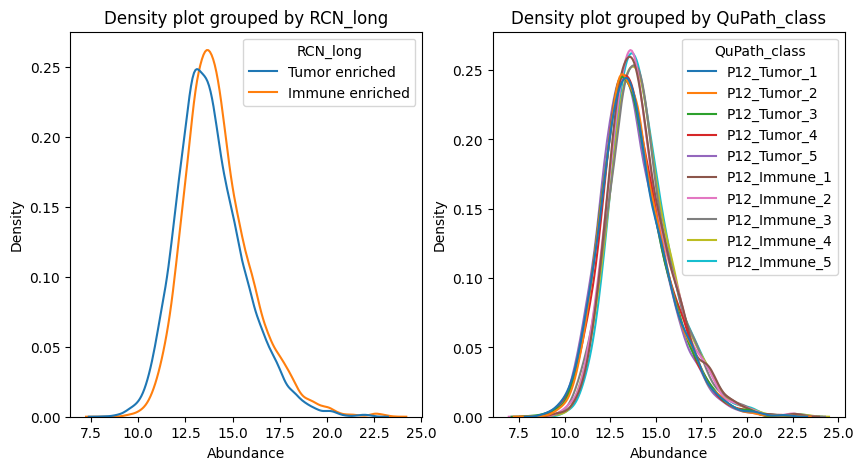

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
dvp.plotting.density(adata=adata, color_by="RCN_long", ax=axes[0])
dvp.plotting.density(adata=adata, color_by="QuPath_class", ax=axes[1])
plt.show()

These density graphs already show us little difference between samples, in terms of overall quantifications.

16:50:41.85 | INFO | no groups passed, using ['Tumor enriched', 'Immune enriched']


/Users/jnimoca/Jose_BI/1_Repositories/openDVP/src/opendvp/plotting/rankplot.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sns = pd.concat([df_sns, group_df])
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


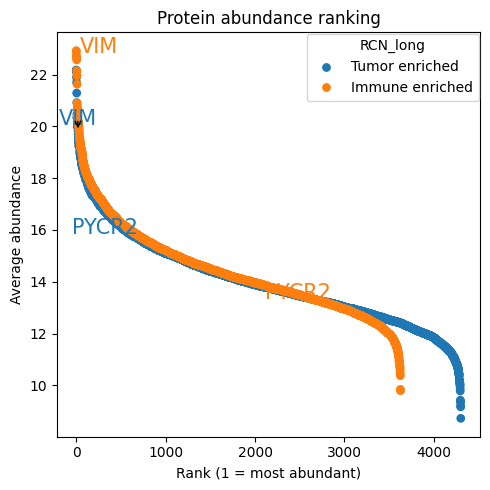

In [15]:
dvp.plotting.rankplot(
    adata=adata, adata_obs_key="RCN_long", min_presence_fraction=0.7, proteins_to_label=["VIM", "PYCR2"]
)

## Preprocess dataset

### Filter dataset by NaNs

We expect a lot of proteins to be removed because this is a subsampled dataset.  
Many protein hits were present in other groups not present here.

In [16]:
adata_filtered = dvp.tl.filter_features_byNaNs(adata=adata, threshold=0.7, grouping="RCN")

16:50:52.54 | INFO | Filtering protein with at least 70.0% valid values in ANY group
16:50:52.54 | INFO | Calculating overall QC metrics for all features.
16:50:52.54 | INFO | Filtering by groups, RCN: ['RCN1', 'RCN3']
16:50:52.54 | INFO |  RCN1 has 5 samples
16:50:52.55 | INFO |  RCN3 has 5 samples
16:50:52.55 | INFO | Keeping proteins that pass 'ANY' group criteria.
16:50:52.55 | INFO | Complete QC metrics for all initial features stored in `adata.uns['filter_features_byNaNs_qc_metrics']`.
16:50:52.56 | INFO | 4637 proteins were kept.
16:50:52.56 | INFO | 2126 proteins were removed.
16:50:52.57 | SUCCESS | filter_features_byNaNs complete.


In [17]:
adata_filtered.uns["filter_features_byNaNs_qc_metrics"].head()

Protein.Group            Protein.Names               Genes  \
Gene                                                                       
TMA7      A0A024R1R8;Q9Y2S6   TMA7B_HUMAN;TMA7_HUMAN          TMA7;TMA7B   
IGLV8-61         A0A075B6I0              LV861_HUMAN            IGLV8-61   
IGLV3-10         A0A075B6K4              LV310_HUMAN            IGLV3-10   
IGLV3-9          A0A075B6K5               LV39_HUMAN             IGLV3-9   
IGKV2-28  A0A075B6P5;P01615  KV228_HUMAN;KVD28_HUMAN  IGKV2-28;IGKV2D-28   

                            First.Protein.Description  overall_mean  \
Gene                                                                  
TMA7      Translation machinery-associated protein 7B        13.391   
IGLV8-61          Immunoglobulin lambda variable 8-61        13.666   
IGLV3-10          Immunoglobulin lambda variable 3-10        14.216   
IGLV3-9            Immunoglobulin lambda variable 3-9        15.293   
IGKV2-28           Immunoglobulin kappa variable 2-28        15.343   

          overall_nan_count  overall_valid_count  overall_nan_proportions  \
Gene                                                                        
TMA7                      5                    5                      0.5   
IGLV8-61                  6                    4                      0.6   
IGLV3-10                  6                    4                      0.6   
IGLV3-9                   0                   10                      0.0   
IGKV2-28                  1                    9                      0.1   

          overall_valid  RCN1_mean  ...  RCN1_nan_proportions  RCN1_valid  \
Gene                                ...                                     
TMA7              False     13.029  ...                   0.4       False   
IGLV8-61          False     12.395  ...                   0.8       False   
IGLV3-10          False     13.335  ...                   0.6       False   
IGLV3-9            True     13.680  ...                   0.0        True   
IGKV2-28           True     14.014  ...                   0.2        True   

          RCN3_mean  RCN3_nan_count  RCN3_valid_count  RCN3_nan_proportions  \
Gene                                                                          
TMA7         13.933               3                 2                   0.6   
IGLV8-61     14.090               2                 3                   0.4   
IGLV3-10     15.097               3                 2                   0.6   
IGLV3-9      16.906               0                 5                   0.0   
IGKV2-28     16.407               0                 5                   0.0   

          RCN3_valid  valid_in_all_groups  valid_in_any_group  \
Gene                                                            
TMA7           False                False               False   
IGLV8-61       False                False               False   
IGLV3-10       False                False               False   
IGLV3-9         True                 True                True   
IGKV2-28        True                 True                True   

          not_valid_in_any_group  
Gene                              
TMA7                        True  
IGLV8-61                    True  
IGLV3-10                    True  
IGLV3-9                    False  
IGKV2-28                   False  

[5 rows x 22 columns]

In [18]:
adata_filtered.uns["filter_features_byNaNs_qc_metrics"].columns

Index(['Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description',
       'overall_mean', 'overall_nan_count', 'overall_valid_count',
       'overall_nan_proportions', 'overall_valid', 'RCN1_mean',
       'RCN1_nan_count', 'RCN1_valid_count', 'RCN1_nan_proportions',
       'RCN1_valid', 'RCN3_mean', 'RCN3_nan_count', 'RCN3_valid_count',
       'RCN3_nan_proportions', 'RCN3_valid', 'valid_in_all_groups',
       'valid_in_any_group', 'not_valid_in_any_group'],
      dtype='object')

In this dataframe, stored away in adata.uns, you can see all th qc metrics of the filtering

In [19]:
# Store filtered adata
dvp.io.export_adata(adata=adata_filtered, path_to_dir="../data/checkpoints", checkpoint_name="2_filtered")

16:50:58.34 | INFO | Writing h5ad
16:50:58.40 | SUCCESS | Wrote h5ad file


### Imputation

In [20]:
adata_imputed = dvp.tl.impute_gaussian(adata=adata_filtered, mean_shift=-1.8, std_dev_shift=0.3)

16:51:00.54 | INFO | Storing original data in `adata.layers['unimputed']`.
16:51:00.54 | INFO | Imputation with Gaussian distribution PER PROTEIN
16:51:00.55 | INFO | Mean number of missing values per sample: 572.6 out of 4637 proteins
16:51:00.55 | INFO | Mean number of missing values per protein: 1.23 out of 10 samples
16:51:02.21 | INFO | Imputation complete. QC metrics stored in `adata.uns['impute_gaussian_qc_metrics']`.


In [21]:
adata_imputed

AnnData object with n_obs × n_vars = 10 × 4637
    obs: 'Precursors.Identified', 'Proteins.Identified', 'Average.Missed.Tryptic.Cleavages', 'LCMS_run_id', 'RCN', 'RCN_long', 'QuPath_class'
    var: 'Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description', 'mean', 'nan_proportions'
    uns: 'filter_features_byNaNs_qc_metrics', 'impute_gaussian_qc_metrics'
    layers: 'unimputed'

Like the previous process, the imputation stores two quality control datasets.  
First, the `impute_gaussian_qc_metrics`
Showing you per protein:
- how many values were imputed
- the distribution used
- the values used to impute with

In [22]:
adata_imputed.uns["impute_gaussian_qc_metrics"]

n_imputed  imputation_mean  imputation_stddev  \
Gene                                                       
IGLV3-9            0        15.292778           1.840310   
IGKV2-28           1        15.343103           1.346909   
IGHV3-64           6        13.710045           1.247562   
IGKV2D-29          0        16.213394           1.481762   
IGKV1-27           0        13.452261           1.394043   
...              ...              ...                ...   
WASF2              0        15.135411           0.255652   
MAU2               1        12.475482           0.455856   
ENPP4              0        12.008373           0.630813   
MORC2              1        12.330734           0.783775   
SEC23IP            0        14.050191           0.227216   

                                              imputed_values  
Gene                                                          
IGLV3-9                                                  NAN  
IGKV2-28                                           [13.0819]  
IGHV3-64   [11.7351, 11.3062, 11.8148, 11.6849, 12.0622, ...  
IGKV2D-29                                                NAN  
IGKV1-27                                                 NAN  
...                                                      ...  
WASF2                                                    NAN  
MAU2                                               [11.6512]  
ENPP4                                                    NAN  
MORC2                                              [10.7016]  
SEC23IP                                                  NAN  

[4637 rows x 4 columns]

Second, the unimputed values are stored inside the layers compartment of the adata object.  
This is a backup in case imputation has done something wrong.  
You can always call those values by `adata_imputed.layers['unimputed']`

In [23]:
dvp.io.export_adata(adata=adata_imputed, path_to_dir="../data/checkpoints", checkpoint_name="3_imputed")

16:51:10.48 | INFO | Writing h5ad
16:51:10.54 | SUCCESS | Wrote h5ad file


## Let's start with the biology

### PCA (courtesy of Scanpy)

In [24]:
sc.pp.pca(adata_imputed)

Scanpy is a very powerful data analysis package created for single-cell RNA sequencing.  
We use it here because it is very convenient, and it already expects the AnnData format we have.  
Beware of using Scanpy for proteomics datasets, assumptions will vary.

In [25]:
adata_imputed

AnnData object with n_obs × n_vars = 10 × 4637
    obs: 'Precursors.Identified', 'Proteins.Identified', 'Average.Missed.Tryptic.Cleavages', 'LCMS_run_id', 'RCN', 'RCN_long', 'QuPath_class'
    var: 'Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description', 'mean', 'nan_proportions'
    uns: 'filter_features_byNaNs_qc_metrics', 'impute_gaussian_qc_metrics', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'unimputed'

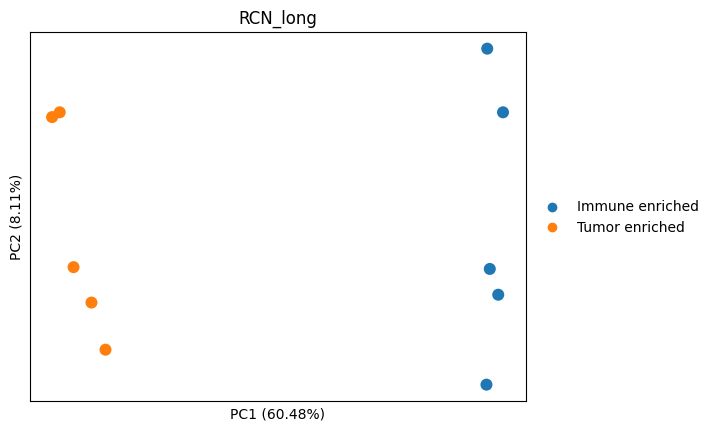

In [26]:
# let's plot it
sc.pl.pca(adata_imputed, color="RCN_long", annotate_var_explained=True, size=300)

19 [ 0.54586545 -0.69229984]
58 [0.65783205 0.95656296]


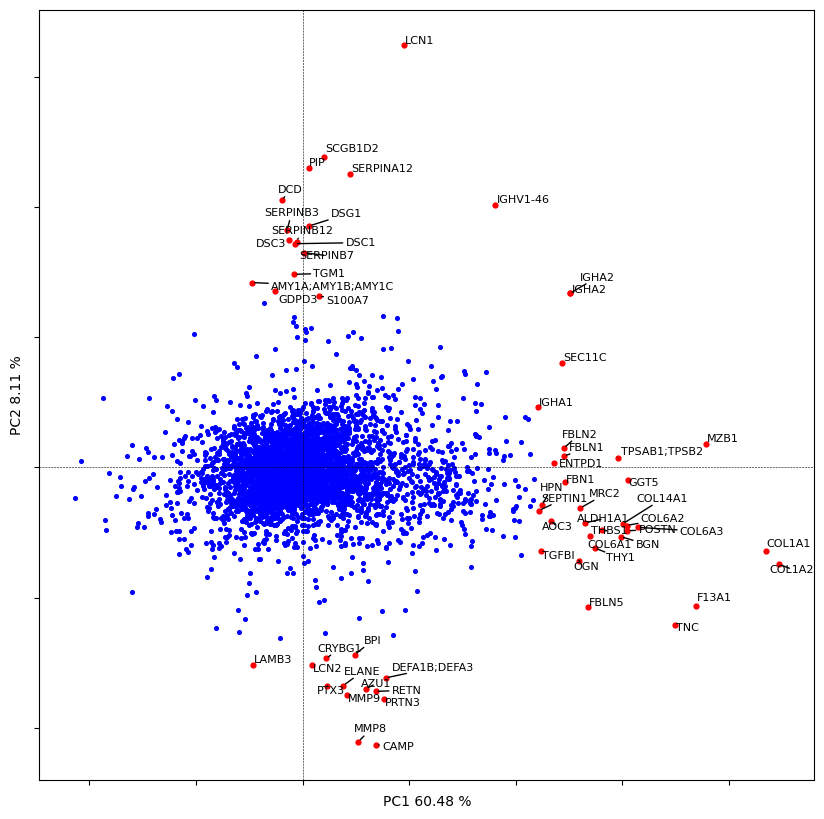

In [27]:
# let's plot the contribution of each protein to the PC1 and PC2
dvp.plotting.pca_loadings(adata_imputed)

In [28]:
dvp.io.export_adata(adata=adata_imputed, path_to_dir="../data/checkpoints", checkpoint_name="4_pca")

16:51:23.73 | INFO | Writing h5ad
16:51:23.78 | SUCCESS | Wrote h5ad file


### Protein intensities to find patterns at high level

/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


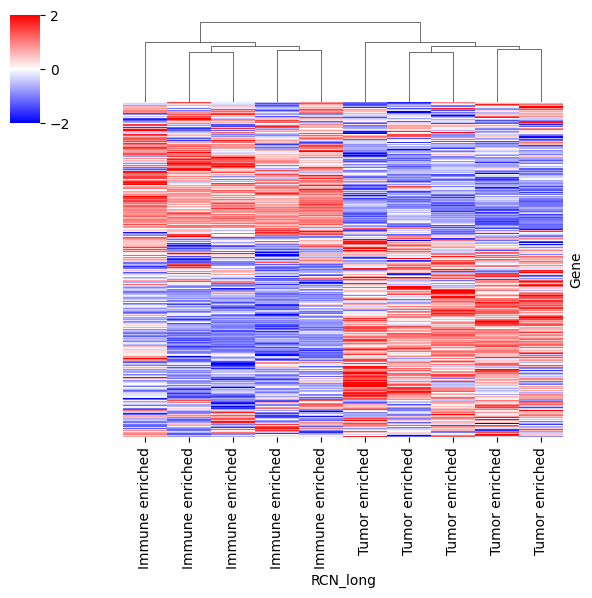

In [29]:
dataframe = pd.DataFrame(data=adata_imputed.X, columns=adata_imputed.var_names, index=adata_imputed.obs.RCN_long)

cm = sns.clustermap(data=dataframe.T, z_score=0, cmap="bwr", vmin=-2, vmax=2, yticklabels=False, figsize=(6, 6))

# to hide dendrogram of proteins
cm.ax_row_dendrogram.set_visible(False)

## Differential analysis

In [30]:
# ttest
adata_DAP = dvp.tl.stats_ttest(
    adata_imputed, grouping="RCN_long", group1="Tumor enriched", group2="Immune enriched", FDR_threshold=0.05
)

16:51:35.87 | INFO | Using pingouin.ttest to perform unpaired two-sided t-test between Tumor enriched and Immune enriched
16:51:35.87 | INFO | Using Benjamini-Hochberg for FDR correction, with a threshold of 0.05
16:51:35.87 | INFO | The test found 2003 proteins to be significantly


In [31]:
adata_DAP

AnnData object with n_obs × n_vars = 10 × 4637
    obs: 'Precursors.Identified', 'Proteins.Identified', 'Average.Missed.Tryptic.Cleavages', 'LCMS_run_id', 'RCN', 'RCN_long', 'QuPath_class'
    var: 'Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description', 'mean', 'nan_proportions', 't_val', 'p_val', 'mean_diff', 'sig', 'p_corr', '-log10_p_corr'
    uns: 'filter_features_byNaNs_qc_metrics', 'impute_gaussian_qc_metrics', 'pca', 'RCN_long_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'unimputed'

In [32]:
dvp.io.export_adata(adata=adata_DAP, path_to_dir="../data/checkpoints", checkpoint_name="5_DAP")

16:51:39.99 | INFO | Writing h5ad
16:51:40.04 | SUCCESS | Wrote h5ad file


### Volcano plot

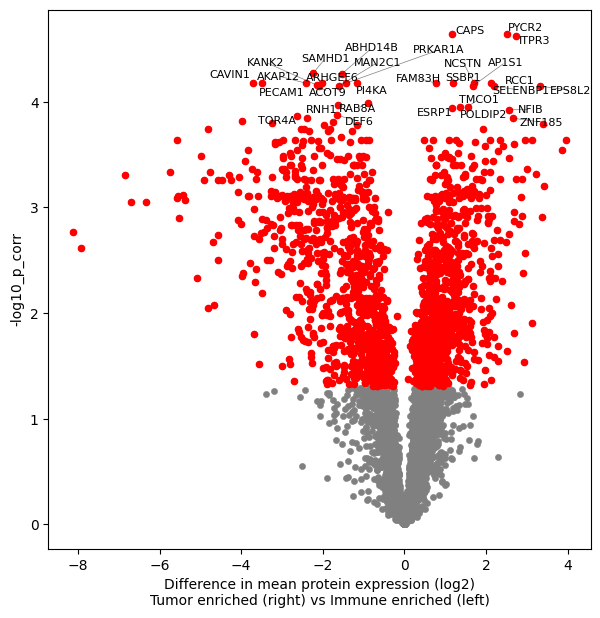

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
dvp.plotting.volcano(
    adata=adata_DAP,
    x="mean_diff",
    y="-log10_p_corr",
    FDR=0.05,
    significant=True,
    tag_top=30,
    group1="Tumor enriched",
    group2="Immune enriched",
    ax=ax,
)